# Notes for geoinformatics
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd
import geodatasets

from pyproj import Geod

In [2]:
# Loading world data for the basemap
world_path = geodatasets.get_path("naturalearth.land")
world = gpd.read_file(world_path)

# Points and Lines
---

LINESTRING (4.8357 45.764, 100 50)
POLYGON ((2.3522 48.8566, 13.405 52.52, 4.8357 45.764, 2.3522 48.8566))


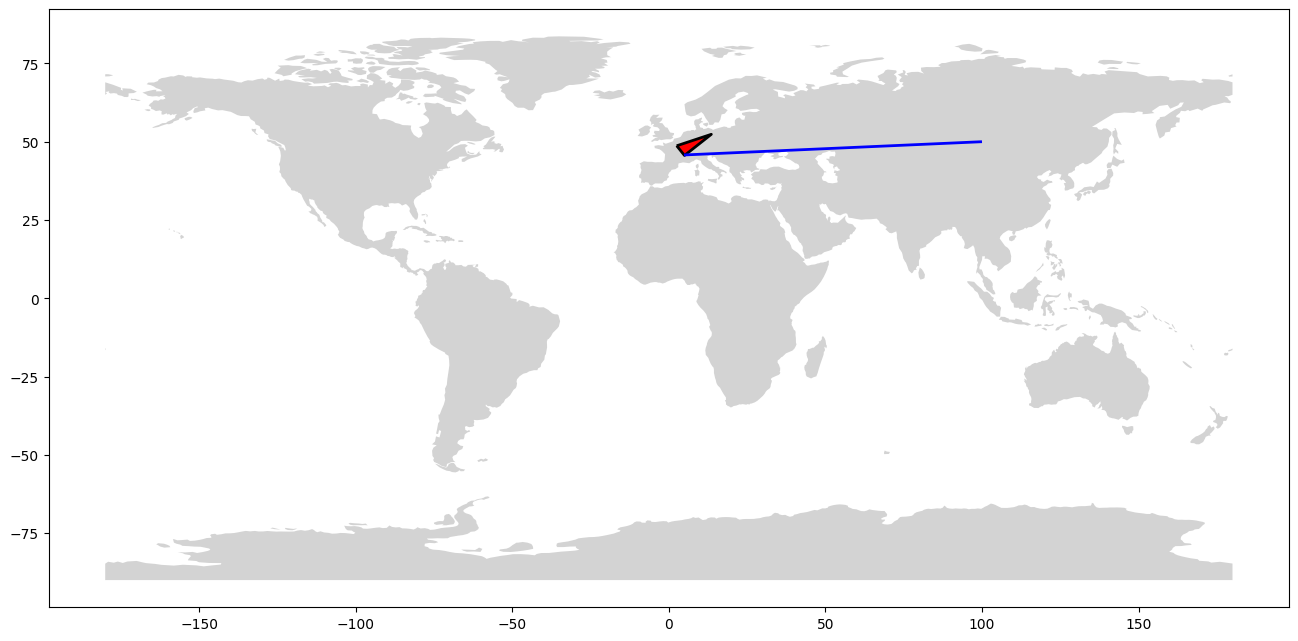

In [3]:
paris = Point(2.3522, 48.8566)
berlin = Point(13.4050, 52.5200)
other = Point(4.8357, 45.7640)
another = Point(100.0, 50.0)

line = LineString([other, another])
print(line)

triangle = Polygon( [ paris, berlin, other ] )
print(triangle)

gdf = gpd.GeoDataFrame(geometry=[line, triangle])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
gdf.plot(ax=ax, color=["blue", "red"], linewidth=2, edgecolor="black")

plt.show()

# Curved Lines
---

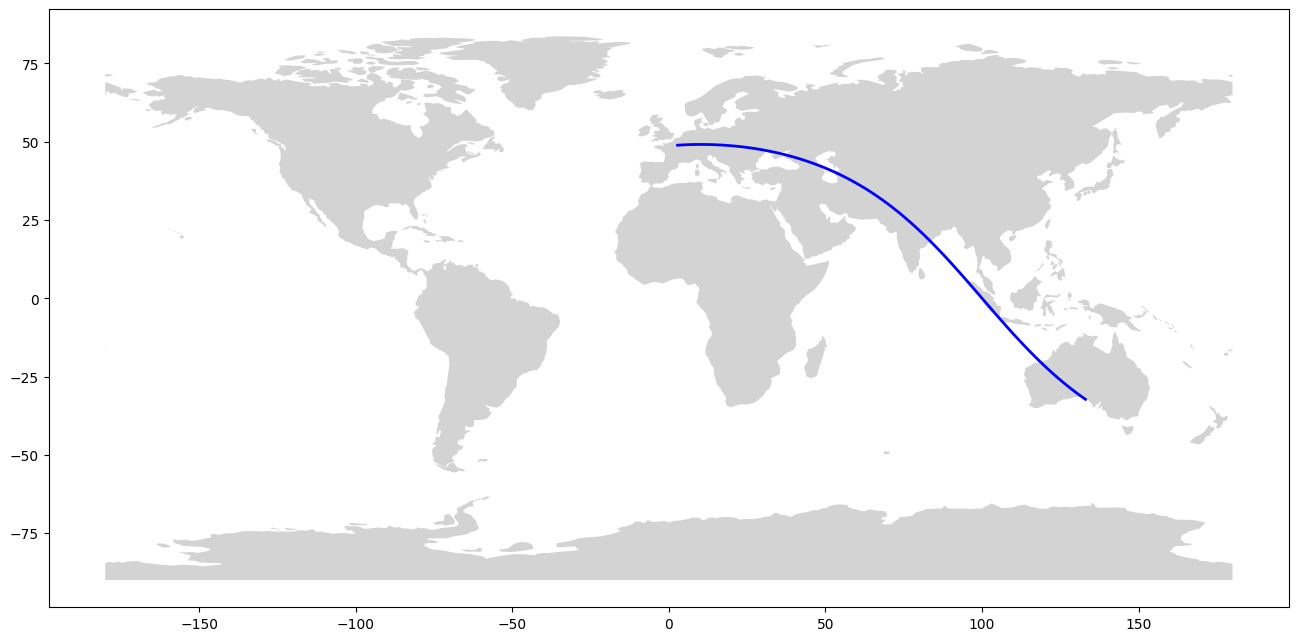

In [4]:
geod = Geod(ellps="WGS84") # Create ellipsoid

num_points = 100 # Adjust for smoothness

paris = (2.3522, 48.8566)
berlin = (133.4050, -32.5200)

points = geod.npts(paris[0], paris[1], berlin[0], berlin[1], num_points)

points.insert(0, paris)
points.append(berlin)

curved_line = LineString(points)

gdf = gpd.GeoDataFrame(geometry=[curved_line])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
gdf.plot(ax=ax, color=["blue"], linewidth=2)

plt.show()

# Polygons
---

In [5]:
melbourne = (144.9631, -37.8142)
bogota = (-74.0722, 4.7111)
paris = (2.3522, 48.8567)
tokyo = (139.6922, 35.6897)

cities = [bogota, melbourne, paris, tokyo]

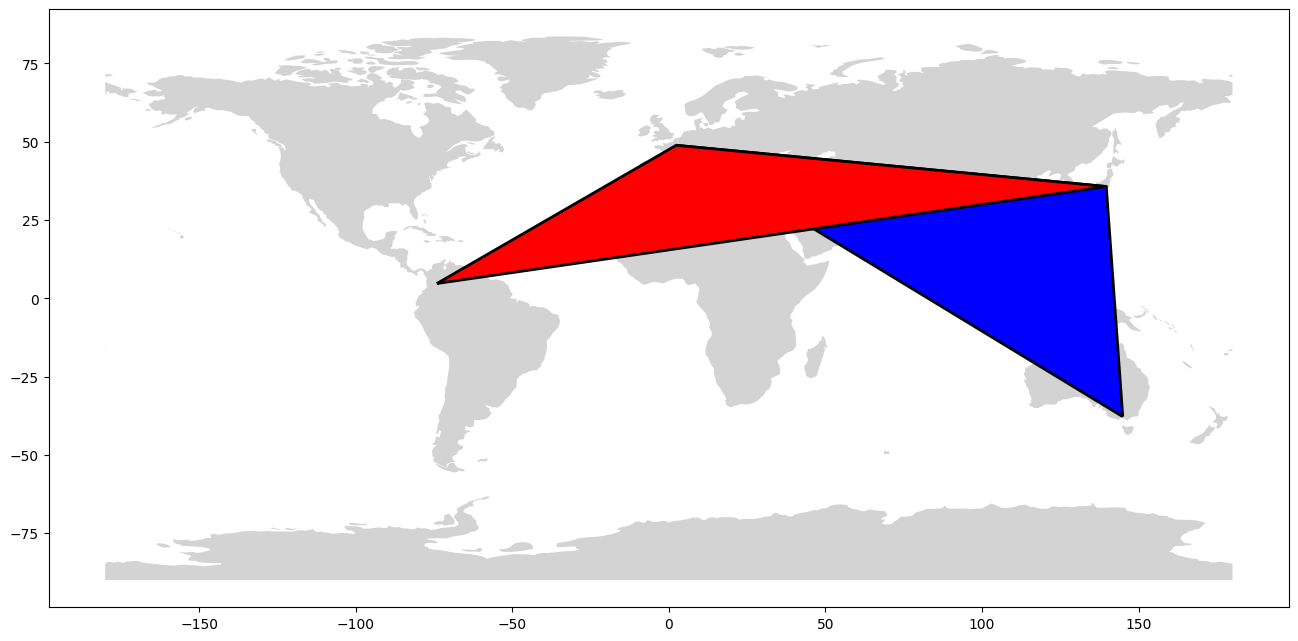

In [6]:
points_a = [Point(*city) for city in cities if city != bogota]
points_b = [Point(*city) for city in cities if city != melbourne]

territory_a = Polygon(points_a)
territory_b = Polygon(points_b)

gdf = gpd.GeoDataFrame(geometry=[territory_a, territory_b])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
gdf.plot(ax=ax, color=["blue", "red"], linewidth=2, edgecolor="black")

plt.show()

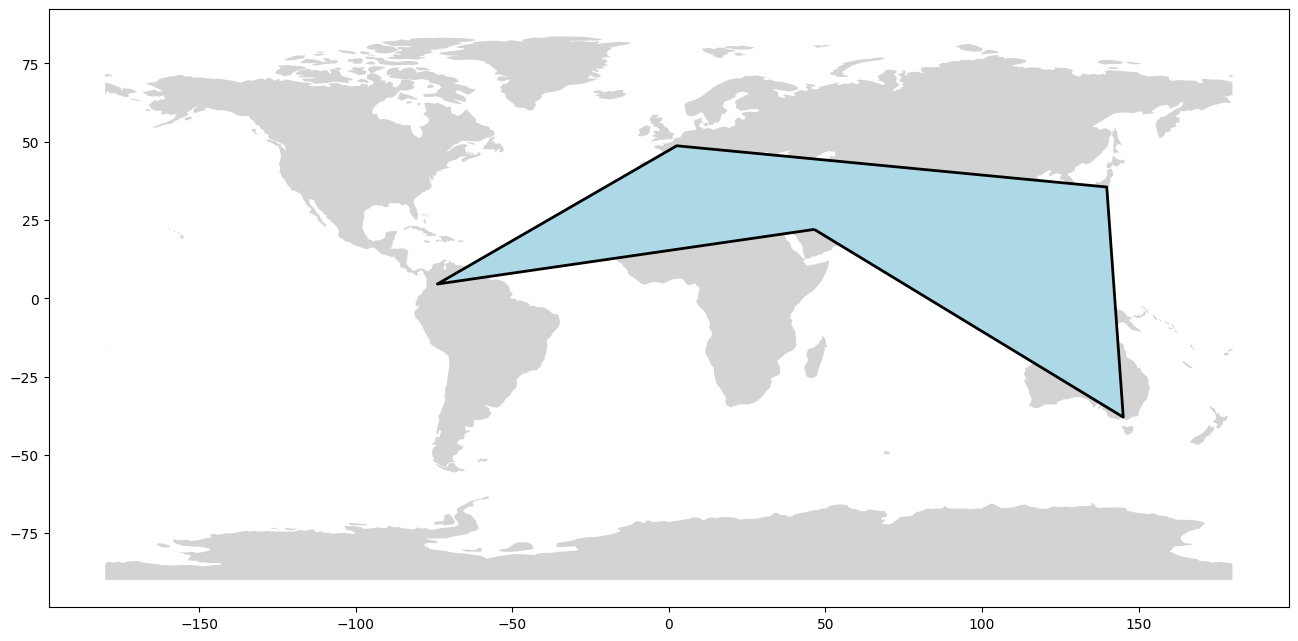

In [7]:
merged_territory = gdf.geometry.union_all()

merged_gdf = gpd.GeoDataFrame(geometry=[merged_territory])

fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color="lightgrey")
merged_gdf.plot(ax=ax, color="lightblue", linewidth=2, edgecolor="black")

plt.show()

# Wind in Hemispheres
---

**North**
- **High**: Anticylonic divergent (*clockwise*)
- **Low** : Cylonic convergent (*counterclockwise*)

**South**
- **High**: Anticyclonic divergent (*counterclockwise*)
- **Low** : Cyclonic convergent (*clockwise*)

In [8]:
spirals_path = geodatasets.get_path("geoda.spirals")

In [9]:
spirals_df = pd.read_csv(spirals_path).astype({"x": float, "y": float})

In [10]:
R = 6_371_000 # Eearths radius in meters

In [11]:
def cartesian_to_geo(x, y, lon0, lat0, z=0, h0=0):
    # Reference point
    lon0_rad = np.radians(lon0)
    lat0_rad = np.radians(lat0)

    # New lat and lon
    lon = lon0 + np.degrees(x / (R * np.cos(lat0_rad)))
    lat = lat0 + np.degrees(y / R)
    h = h0 + z

    return lon, lat, h


In [12]:
def geo_to_cartesian(lon, lat, lon0, lat0, h, h0):
    # Reference point
    lon0_rad = np.radians(lon0)
    lat0_rad = np.radians(lat0)

    # x (East), y (North), z (Up)
    x = (np.radians(lon - lon0) * R * np.cos(lat0_rad))
    y = (np.radians(lat - lat0) * R)
    z = h - h0 # Difference in height

    return x, y, z

In [13]:
def get_spiral_gdf(df, x_name, y_name, lon=0, lat=0, x_scale=1, y_scale=1):
    spirals_df["lng"] = df.apply(lambda row: cartesian_to_geo(row[x_name] * x_scale, row[y_name] * y_scale, lon, lat)[0], axis=1)
    spirals_df["lat"] = df.apply(lambda row: cartesian_to_geo(row[x_name] * x_scale, row[y_name] * y_scale, lon, lat)[1], axis=1)

    spiral_points = [Point(x, y) for x, y in zip(spirals_df["lng"], spirals_df["lat"])]

    spiral_gdf = gpd.GeoDataFrame(geometry=spiral_points)

    return spiral_gdf

In [14]:
def get_pressure_gdf(df, mode : str, lon=0, lat=0, x_scale=1, y_scale=1):
    if mode not in ["h", "l"]:
        raise NameError("Mode unsupportet")
    elif x_scale <= 0 or y_scale <= 0:
        raise ValueError("Scale has to be greater than zero")

    x_sgn, y_sgn = 1, 1
    color = "green"

    # South
    if lat <= 0:
        # Low
        if mode == "l":
            color = "blue"
        # High
        elif mode == "h":
            color = "red"
            y_sgn = - 1
    # North
    elif lat > 0:
        if mode == "l":
            color = "blue"
            y_sgn = -1
        elif mode == "h":
            color = "red"

    gdf = get_spiral_gdf(df, "x", "y", lon, lat, x_sgn * x_scale, y_sgn * y_scale)

    return (gdf, color)

In [15]:
# City, lon, lat
bogota = (-74.0722, 4.7111)
comodoro_rivadavia = (-67.4808, -45.8647)
delhi = (77.2300, 28.6100)
east_london = (27.9047, -33.0175)
jakarta = (106.8275, -6.175)
lagos = (3.3841, 6.4550)
melbourne = (144.9631, -37.8142)
paris = (2.3522, 48.8567)
san_francisco = (-122.4449, 37.7558 )
tokyo = (139.6922, 35.6897)
toronto = (-79.3733, 43.7417)

cities = [bogota, comodoro_rivadavia, delhi, east_london, jakarta, lagos, melbourne, paris, tokyo, san_francisco, toronto]

In [16]:
from random import random

In [17]:
cities = sorted(cities, key=lambda x :random())

In [18]:
scale = 1_000_000
low = [ get_pressure_gdf(spirals_df, "l", city[0], city[1], scale, scale) for i, city in enumerate(cities) if i % 2 == 0]
high = [ get_pressure_gdf(spirals_df, "h", city[0], city[1], scale, scale) for i, city in enumerate(cities) if i % 2 == 1]
pressure_systems = low + high

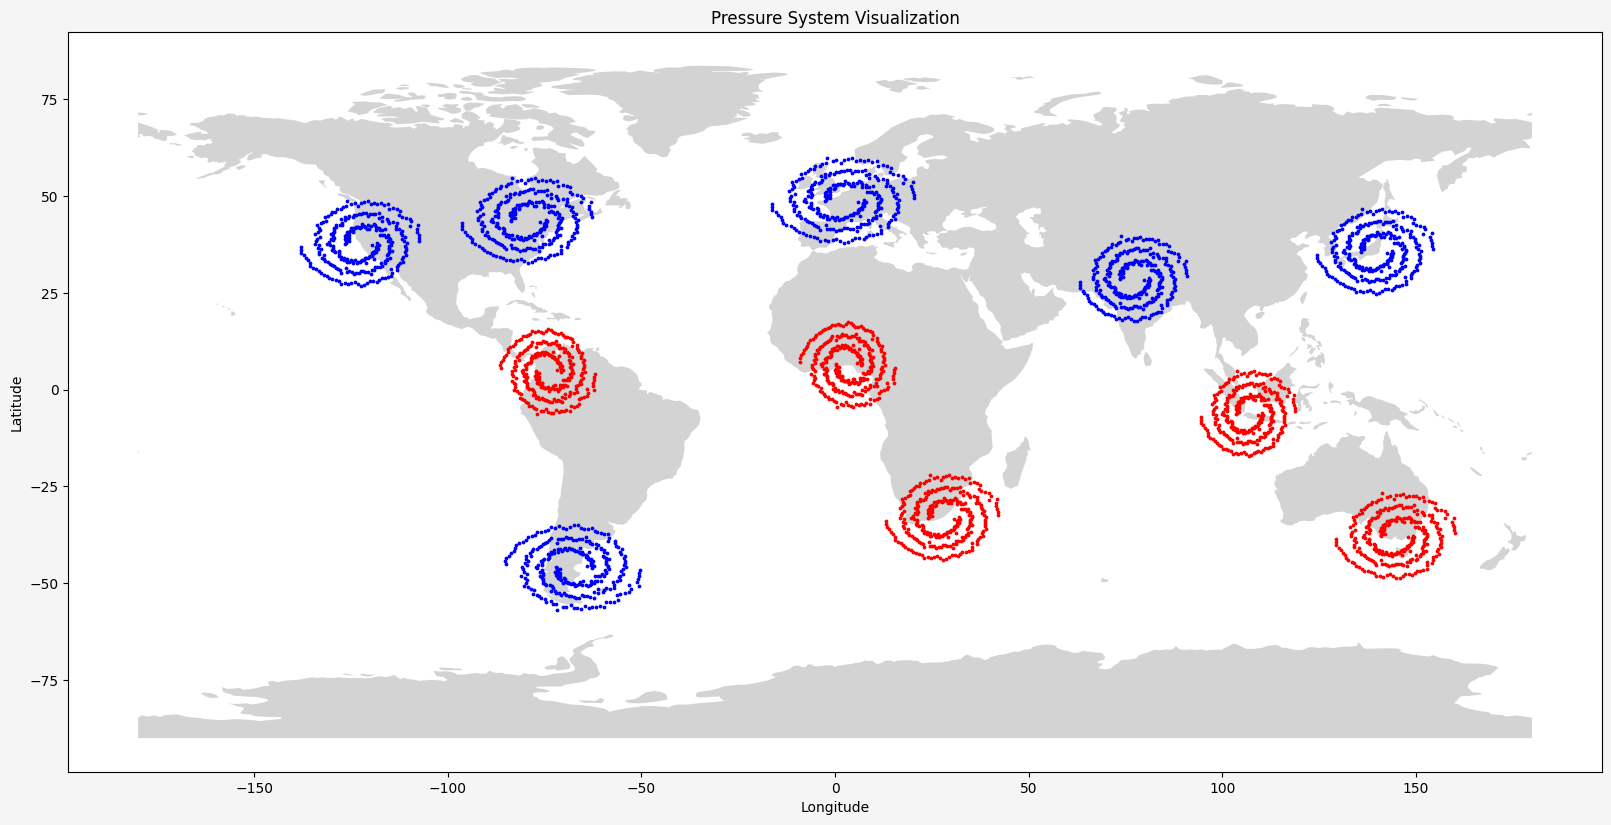

In [19]:
fig, ax = plt.subplots(figsize=(16, 9), facecolor="whitesmoke", layout="constrained")
world.plot(ax=ax, color="lightgrey")

for pressure_system in pressure_systems: 
    pressure_system[0].plot(ax=ax, marker="o", markersize=3, color=pressure_system[1])
    

ax.set_title("Pressure System Visualization")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [20]:
# Section yet to be written...